#  Collision Data Handling Practice 2
> yongbinlee
> 19011810

# 0. Introduction
In this work, we aim to create x_train and y_train datasets to train Neural Network (NN) models such as MLP, CNN, and LSTM. The process involves several key steps: first, extracting features from the raw dataset; second, normalizing this data; third, structuring the data into the correct input format for the NN; and fourth, balancing the dataset. For our input, we utilize the absolute value of r(t). This choice is driven by the fact that for collision detection, the magnitude of the r(t) value is of primary importance, rather than its direction. Consequently, all r(t) values are preprocessed by taking their absolute values. Subsequently, these values are normalized to a range of 0 to 1, a format well-suited for training NN models.

In [335]:
# import library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [336]:
# column name for declare and drop
column_names = (
    ["time", "collision_index"]
    + [f"p{i+1}" for i in range(6)]            # p(t): generalized momentum
    + [f"beta{i+1}" for i in range(6)]         # β(t): from robot dynamics
    + [f"tau_m{i+1}" for i in range(6)]        # τm(t): active motor torques
)

rm_column_names = (
    [f"p{i+1}" for i in range(6)]            # p(t): generalized momentum
    + [f"p_hat_dot_pred{i+1}" for i in range(6)] 
    + [f"p_hat_pred{i+1}" for i in range(6)] 
    + [f"beta{i+1}" for i in range(6)]         # β(t): from robot dynamics
    + [f"tau_m{i+1}" for i in range(6)]        # τm(t): active motor torques
)

n_joints = 6

In [337]:
# file load
test_files_num = 94 # number of collision data for test
train_files_num = 135 # number of collision data for training

df_coll_test = {}
df_coll_train = {}

df_test = pd.read_csv('/Users/iyongbin/Repository/ai_robotics/data/free_test.csv', names=column_names)
df_train1 = pd.read_csv('/Users/iyongbin/Repository/ai_robotics/data/free_train_1.csv', names=column_names)
df_train2 = pd.read_csv('/Users/iyongbin/Repository/ai_robotics/data/free_train_2.csv', names=column_names)

for i in range(1, test_files_num + 1):
    df_coll_test[i - 1] = pd.read_csv(f'/Users/iyongbin/Repository/ai_robotics/data/collisions/coll_test_{i}.csv', names=column_names) 
for i in range(1, train_files_num + 1):
    df_coll_train[i - 1] = pd.read_csv(f'/Users/iyongbin/Repository/ai_robotics/data/collisions/coll_train_{i}.csv', names=column_names)

print(df_test.shape, df_train1.shape, df_train2.shape)
print(df_coll_test[0].shape, df_coll_train[0].shape)

(61890, 20) (62559, 20) (61890, 20)
(280, 20) (280, 20)


In [338]:
df_train1.head()

,time,collision_index,p1,p2,p3,p4,p5,p6,beta1,beta2,beta3,beta4,beta5,beta6,tau_m1,tau_m2,tau_m3,tau_m4,tau_m5,tau_m6
0,0.01,0,0.0,0.0,0.0,0.0,0.0,0.0,-9.234000e-15,137.349,62.643,-9.3768,2.00175,-0.005649,-0.54,145.26,57.6,-4.2336,1.9488,-0.739200
1,0.02,0,0.0,0.0,0.0,0.0,0.0,0.0,-9.234000e-15,137.349,62.643,-9.3768,2.00175,-0.005649,-0.54,145.26,57.6,-4.2336,1.9488,-0.739200
2,0.03,0,0.0,0.0,0.0,0.0,0.0,0.0,-9.234000e-15,137.349,62.643,-9.3768,2.00175,-0.005649,-0.54,145.26,57.6,-4.2336,1.9488,-0.739200
3,0.04,0,0.0,0.0,0.0,0.0,0.0,0.0,-7.949029e-15,137.349,62.643,-9.3768,2.00175,-0.005649,-0.54,145.26,57.6,-4.2336,1.9488,-0.748444
4,0.05,0,0.0,0.0,0.0,0.0,0.0,0.0,-6.503436e-15,137.349,62.643,-9.3768,2.00175,-0.005649,-0.54,145.26,57.6,-4.2336,1.9488,-0.758044


# 1. Last works

In a previous report, we developed a function for the Momentum Observer (MOB). In this work, we will utilize this function again, but with an added option to remove the first 20 rows of data. This modification addresses an initial value problem: when the robot begins to move, some noise can occur, which might interfere with accurately determining the maximum and minimum values of |r(t)|. Therefore, data corresponding to the first 200ms from the beginning of each recording will be deleted, regardless of the dataset type (e.g., training, test, collision, or collision-free).

In [339]:
## function from last assignment

# calculate rm value
def mob(df, K0=150.0, n_joints=6, dt=0.01, remove_200ms=True):
    n_shape = df.shape[0]
    for col_num in range(1, n_joints + 1):
        df[f'p_hat_pred{col_num}'] = 0
        df[f'rm_pred{col_num}'] = 0

    for col_num in range(1, n_joints + 1):
        p = df[f'p{col_num}'].values
        tau_m = df[f'tau_m{col_num}'].values
        beta = df[f'beta{col_num}'].values
        p0 = 0.0

        p_hat_pred = np.zeros(n_shape)
        rm_pred = np.zeros(n_shape)
        p_hat_dot_pred = np.zeros(n_shape)

        # initialization
        p_hat_pred[0] = p[0]
        rm_pred[0] = 0.0
        p_hat_dot_pred[0] = tau_m[0] - beta[0] + rm_pred[0]

        for t in range(1, n_shape):
            p_hat_dot_pred[t] = tau_m[t] - beta[t] + rm_pred[t-1]
            p_hat_pred[t] = p_hat_pred[t-1] + p_hat_dot_pred[t] * dt
            rm_pred[t] = K0 * (p[t] - p_hat_pred[t] - p0)

        df[f'p_hat_pred{col_num}'] = p_hat_pred
        df[f'rm_pred{col_num}'] = rm_pred
        df[f'r{col_num}'] = np.abs(rm_pred)
        df[f'p_hat_dot_pred{col_num}'] = p_hat_dot_pred

    if remove_200ms:
        # remove first 200ms
        df.drop(df.index[:20], inplace=True)
    return df

# epsilon threashold 
def calculate_epsilon(df, m=1.1, n_joints=6):
    return np.array(df[[f'rm_pred{i}' for i in range(1, n_joints + 1)]].max().values * m)

# colision detection
def calculate_colision_index(df, e, n_joints=6):
    n_shape = df.shape[0]
    result = np.zeros(n_shape)

    for col_num in range(1, n_joints+1):
        result = np.logical_or(result, np.abs(df[f'rm_pred{col_num}'].values) > e[col_num - 1])
    df['collision_index_pred'] = result.astype('int64')

    return df

# make graph
def plot_mob(df):
    plt.figure(figsize=(8, 5))
    # (a) r_m(t) 6 joints
    for i in range(1, 7):
        plt.plot(df['time'], df[f'rm_pred{i}'], label=f'rm_{i}')

    # (b) real collision
    plt.plot(df['time'], df['collision_index'] * -1000, 'k--', label='Real Collision')

    # (c) predicted collision
    plt.plot(df['time'], df['collision_index_pred'] * 1000, 'r--', label='Predicted Collision')
    plt.title('Collision Detection Comparasion')
    plt.xlabel('Time (s)')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()

In [340]:
# mob

## mob all of the dataset to extract feature data r and remove first 200ms columns

df_train1 = mob(df_train1)
df_train2 = mob(df_train2)
df_test = mob(df_test)

for i in range(train_files_num):
    df_coll_train[i] = mob(df_coll_train[i])

for i in range(test_files_num):
    df_coll_test[i] = mob(df_coll_test[i])

print(df_test.shape, df_train1.shape, df_train2.shape)
print(df_coll_test[0].shape, df_coll_train[0].shape)

(61870, 44) (62539, 44) (61870, 44)
(260, 44) (260, 44)


# 2. Exercise

## 2.1 Exercise 1 Data Preparation and Normalization
The primary goal of Exercise 1 is to prepare the |r(t)| data that will be used for training the neural network and to transform it into a suitable format for learning. As mentioned in the Introduction, we will use the absolute value of r(t) and normalize it.

### (a) Calculation of Maximum and Minimum Values of |r(t)|

First, we determine the maximum (r_max) and minimum (r_min) values of |r(t)| for each of the 6 joints across the entire training dataset (including both collision and collision-free data). This step is crucial for understanding the overall distribution of the data and for establishing the basis for the subsequent normalization phase.

- Handling Collision Training Data: For the "coll_train_1-135.csv" files, the first 20 steps (200 ms) of r(t) data are excluded from the r_max and r_min calculations to account for potential noise at the beginning of each file. This helps to reduce the impact of initial unstable signals on the overall statistics.
- Considering Total Training Time (T_train): r_max and r_min are calculated considering approximately 20 minutes of collision-free training data and 135 collision training files with the initial 200ms removed (approximately 2.6 seconds × 135).

In [341]:
# concat dataset
df_train_list = [df_coll_train[i] for i in range(train_files_num)]

df_train_list.extend([df_train1, df_train2])
len(df_train_list)

df_train = pd.concat(df_train_list, axis=0)
print(df_train.shape)

(159509, 44)


In [342]:
# Scaler Calss for normalization
class Normalizer:
    def __init__(self, n_joints=6):
        self.n_joints = n_joints
        self.scaler = []
        self.trigger = True

    def train_scaling(self, df): # for train dataset, to find the min max value of robot free motion dataset
        if self.trigger == False:
            raise Exception('class is already trained')
        else:
            self.trigger = False

        for i in range(1, self.n_joints+1):
            r = df[f'r{i}']
            s = StandardScaler()
            r_normalized = s.fit_transform(r)
            self.scaler.append(s)
            df[f'r_normalized{i}'] = r_normalized
        return df
    
    def test_scaling(self, df): # for test dataset, apply min max value that find in train_scaling
        for i in range(1, self.n_joints+1):
            r = df[f'r{i}'].values
            s = self.scaler[i-1]
            r_normalized = s.transform(r)
            df[f'r_normalized{i}'] = r_normalized
        return df
        

# to scaling from 0 to 1, based in formula in assignment 3
class StandardScaler: 
    def fit_transform(self, data):
        self.min = np.min(data)
        self.max = np.max(data)
        return (data - self.min) / (self.max - self.min)

    def transform(self, data):
        return (data - self.min) / (self.max - self.min)
    
    def extract_minmax(self):
        return self.min, self.max

In [343]:
scale_model = Normalizer()
# To fit Normalizer to train dataset

# normalize train data
df_train = scale_model.train_scaling(df_train)

# normalize test data
df_train1 = scale_model.test_scaling(df_train1)
df_train2 = scale_model.test_scaling(df_train2)
df_test = scale_model.test_scaling(df_test)

for i in range(test_files_num):
    df_coll_test[i] = scale_model.test_scaling(df_coll_test[i])
for i in range(train_files_num):
    df_coll_train[i] = scale_model.test_scaling(df_coll_train[i])



# print min, max values
for i, scaler in enumerate(scale_model.scaler):
    r_min, r_max = scaler.extract_minmax()
    print(f'r{i+1} - min: {r_min:.6f}, max: {r_max:.6f}')
    # print(f'r{i+1} - min: {r_min}, max: {r_max}')

r1 - min: 0.000000, max: 733.685803
r2 - min: 0.000136, max: 809.251213
r3 - min: 0.000391, max: 434.950263
r4 - min: 0.000065, max: 158.924700
r5 - min: 0.000167, max: 95.240191
r6 - min: 0.000673, max: 53.020238


When we examine the values, we observe that r_min = [0.00, 0.00, 0.00, 0.00, 0.00, 0.00] and r_max = [733.69, 809.25, 434.95, 158.92, 95.24, 53.02]. This means that the minimum value for all joints is 0, while the maximum value varies depending on the joint. Therefore, in the next step, we need to normalize these values to analyze how normalization influences collision detection.

### (b) Data Normalization and Visualization:
Using the r_max and r_min values obtained in step (a), we normalize the |r(t)| values of both training and test data (including collision and collision-free data) to a range between 0 and 1. The normalization formula is:
$$
|r_j(t)|_{normalized} = \frac{|r_j(t)| - r_{min},j}{r_{max},j - r_{min},j}
$$
This normalization process unifies the scale of |r(t)| values across different joints, enabling the neural network model to learn more effectively.

To verify the effect of normalization, we plot the |r(t)| data for the files "coll_train_71.csv", "coll_test_15.csv", and "free_test.csv" 1) before normalization and 2) after normalization. This allows for a visual inspection of how normalization affects the data distribution.

In [344]:
# plot function 
def plot_data_normalized(df, title="sample", n_joints=6):
    plt.figure(figsize=(12, 8))
    for i in range(1, n_joints+1):
        plt.subplot(221)
        plt.plot(df[f"r{i}"], label=f"r{i} (raw)")
        plt.title(f"{title}")
        plt.ylabel(f"r{i}")
        plt.legend()
        plt.subplot(222)
        plt.plot(df[f"r_normalized{i}"], label=f"r{i} (normalized)")
        plt.title(f"normalized {title} ")
        plt.ylabel(f"r_normalized{i}")
        plt.legend()
    plt.tight_layout()
    plt.show()

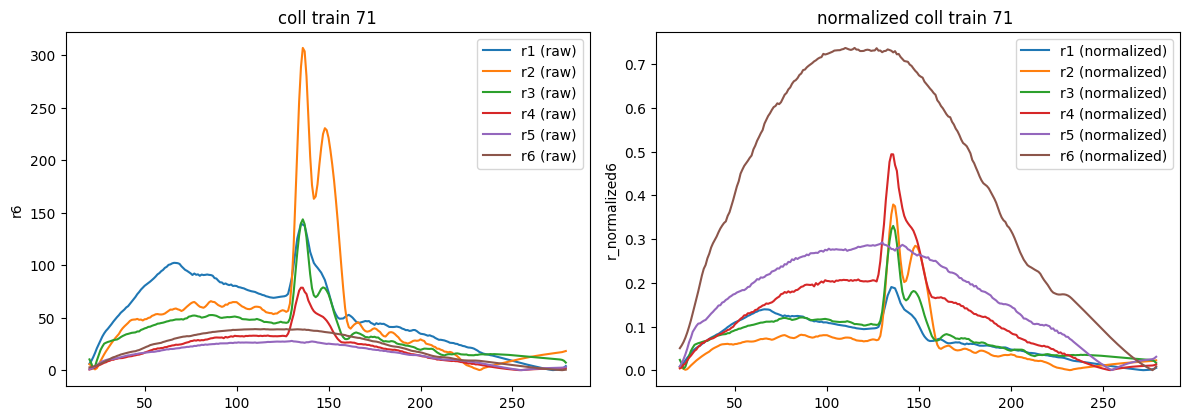

In [345]:
# coll train 71 dataset
sample = scale_model.test_scaling(df_coll_train[71])
plot_data_normalized(sample, title='coll train 71')

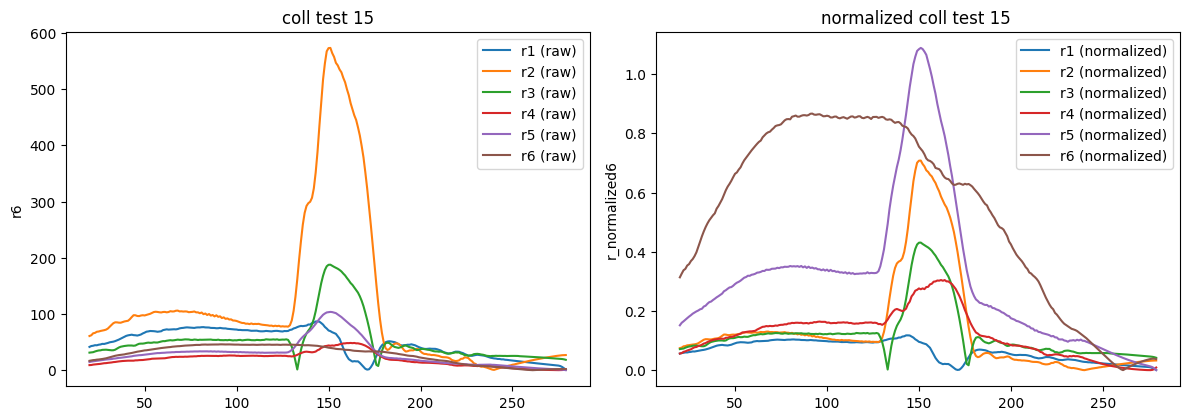

In [346]:
# coll test 15 dataset
sample = df_coll_test[14]
plot_data_normalized(sample, title='coll test 15')

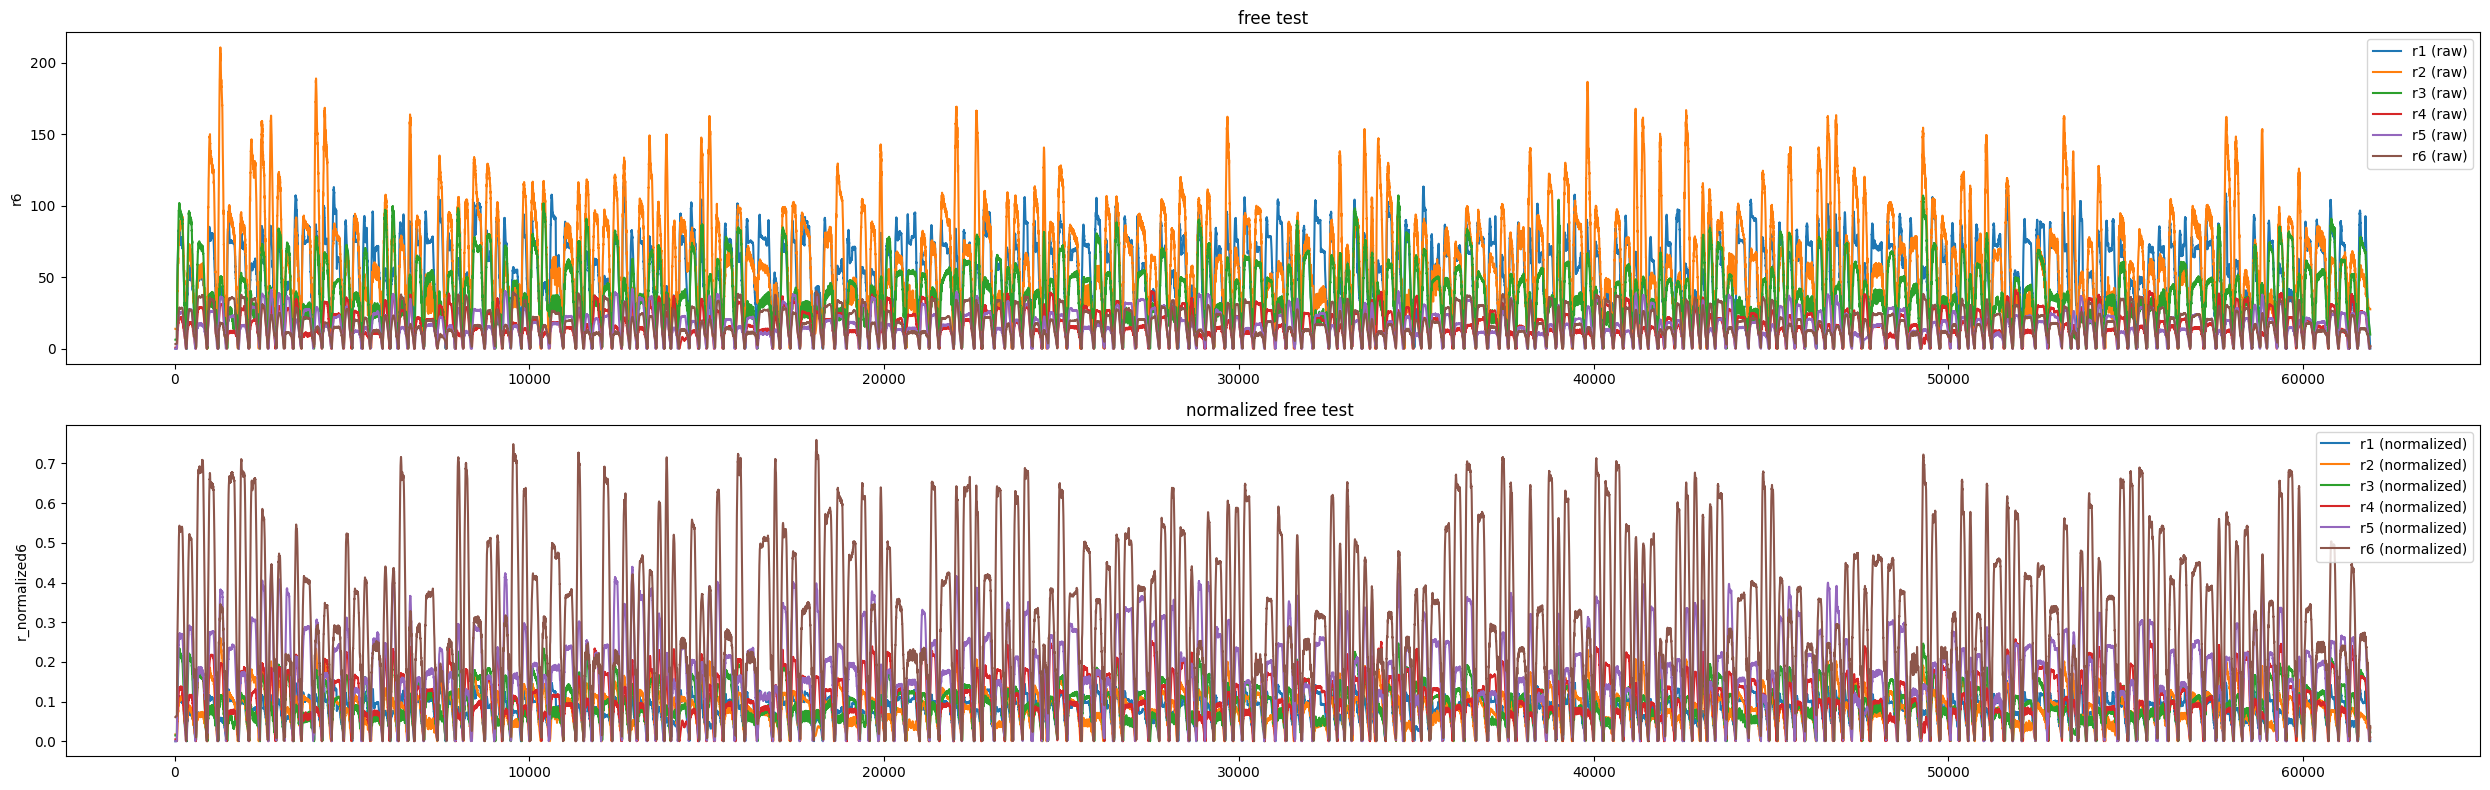

In [347]:
# free test dataset

def plot_data_normalized2(df, title="sample", n_joints=6):
    plt.figure(figsize=(25, 8))
    for i in range(1, n_joints+1):
        plt.subplot(211)
        plt.plot(df[f"r{i}"], label=f"r{i} (raw)")
        plt.title(f"{title}")
        plt.ylabel(f"r{i}")
        plt.legend()
        plt.subplot(212)
        plt.plot(df[f"r_normalized{i}"], label=f"r{i} (normalized)")
        plt.title(f"normalized {title} ")
        plt.ylabel(f"r_normalized{i}")
        plt.legend()
    plt.tight_layout()
    plt.show()

sample = df_test
plot_data_normalized2(sample, title='free test')

To verify the effect of normalization, we plot the |r(t)| data for the files "coll_train_71.csv", "coll_test_15.csv", and "free_test.csv" 1) before normalization and 2) after normalization. This allows for a visual inspection of how normalization affects the data distribution.

Regarding the "coll_train_71.csv" graph, we observe that the data is well normalized, with the maximum value remaining below 1.0. This is expected since it is part of the training data, which should be normalized appropriately. However, in the "coll_test_15.csv" graph, some values exceed 1.0. This could potentially lead to incorrect predictions by the model. To address this, it may be beneficial to ensure that test data values are also constrained below 1.0, either by capping the maximum value in the test set or by introducing a margin (e.g., scaling with a 120% margin) during normalization based on the training data. This adjustment can help improve the model's robustness. In contrast, the "free_test.csv" graph shows that all values are below 1.0, indicating that the normalization has been applied correctly for this dataset.


## 2.2 Exercise 2 : Feature Extraction and Training Dataset Construction

In Exercise 2, we design and extract input features from the normalized |r(t)| data (from Exercise 1) to construct the final training dataset X_train for the neural network model.

### (a) Extraction of Collision-Labeled Input Features (X_coll):
From the training collision data (“coll_train_1–135.csv"), we generate a set of features representing collision events, denoted as X_coll = {x | label(x) = True}. Here, each feature x represents a segment of the normalized |r(t)| over a certain time interval.

Sliding Time Window: To capture temporal patterns, a sliding window technique is employed. The window size (t_w), signal sampling interval (t_I, i.e., stride), and the joint signals to use (all 6 joints or a subset) are hyperparameters that can influence model performance.

- Feature Shape: Each window is structured as a 2D array (or matrix) of shape (t_w_steps, num_selected_joints), thereby incorporating both temporal information and multi-joint data. This format is suitable for time-series processing models like CNNs or LSTMs.
Labeling: If an actual collision occurs within the time interval covered by a window (i.e., the original data's collision index is 1), the feature x extracted from that window is included in X_coll.
- Exclusion of Initial Data: Consistent with Exercise 1(a), the first 20 steps of the "coll_train_*" files are also excluded during this feature extraction process.

In [348]:
def extract_data(df):
    r_normalized_col = [f'r_normalized{i}' for i in range(1, n_joints + 1)]
    data = df[r_normalized_col].values
    label = df['collision_index'].values
    return data, label

def feature_extract(data, label, num_window_steps=6, stride=1, label_type=None):
    features = []
    for i in range(0, len(label) - num_window_steps + 1, stride):
        window_data = data[i : i + num_window_steps, :] 
        window_label = label[i : i + num_window_steps]

        if label_type == 'collision':
            if np.all(window_label == 1):
                break
            if np.any(window_label == 1):
                features.append(window_data)
        elif label_type == 'free':
            if np.all(window_label == 0):
                features.append(window_data)
        else:
            features.append(window_data)

    return features

In [349]:
collision_features = []
for i in range(train_files_num):
    data, label = extract_data(df_coll_train[i])
    features = feature_extract(data, label, num_window_steps=10, stride=1, label_type='collision')
    collision_features.extend(features)


X_coll = np.array(collision_features)
X_coll.shape

(1228, 10, 6)

In the collision training data, we extract collision segments using a sliding window approach. In this work, we set the window size to 10 and the stride to 1. This choice is motivated by the intention to use serial data in real-time during model prediction. If the collision index is detected even once within the label data of a window, we consider that a collision has occurred. However, for windows where all labels indicate a collision (i.e., the entire window is within a collision event), we do not include these in the collision feature dataset. This is because we aim to train the model to recognize the precise moment when a collision actually occurs, rather than periods where the system is already in a sustained collision state.

### (b) Extraction of Collision-Free-Labeled Input Features (X_free):
From the training collision-free motion data (“free_train_1.csv” and “free_train_2.csv”), we generate a set of features representing non-collision events, denoted as X_free = {x | label(x) = False}.

Identical Feature Extraction Method: When extracting X_free, the same sliding window size (t_w), sampling interval (t_I), and joint signal settings used in (a) are applied. This ensures that features in X_coll and X_free have the same dimension (size) and structure, maintaining consistency for model training.
Labeling: If the entire time interval covered by a window corresponds to a non-collision event, the feature x extracted from that window is included in X_free.

In [ ]:
free_features = []

for df in [df_train1, df_train2]:
    data, label = extract_data(df)
    features = feature_extract(data, label, num_window_steps=10, stride=1, label_type='free')
    free_features.extend(features)

X_free = np.array(free_features)
X_free.shape

(124391, 10, 6)

In this step, we extract the dataset from the collision-free training data to use as part of the training set. Since all of this data is already known to be collision-free, there is no need to check for collision events. We simply segment the data using a sliding window and add these segments to the feature list. It is important to maintain the sequential structure of the data, as the model will later require time-series input. Therefore, instead of randomly slicing the data, we ensure that the extracted features preserve the temporal sequence, matching the format required for model training and maintaining the integrity of the overall sequence.

### (c) Balancing the Dataset and Constructing the Final X_train:
In real-world scenarios, the amount of collision-free data can be significantly larger than collision data. Such data imbalance can lead to biased model learning, favoring the majority class. Therefore, a dataset balancing step is necessary.

Setting the Ratio R: A ratio R (where R < #X_free / #X_coll) representing the desired proportion of collision-free features to collision features is set as a hyperparameter.
Subsampling X_free: R × #X_coll features are randomly selected from X_free to form a subset X_free'. That is, #X_free' = R × #X_coll. This adjusts the number of collision-free data points proportionally to the number of collision data points.
Final Training Data X_train: The final training data X_train is constructed by combining the collision features X_coll with the balanced collision-free features X_free': X_train = X_coll ∪ X_free'. Corresponding labels y_train (collision: 1, non-collision: 0) are also generated.
The X_train and y_train datasets prepared through these steps can then be used to train various neural network models as mentioned in the Introduction.

In [351]:
# (C)
num_x_coll = X_coll.shape[0]
num_x_free = X_free.shape[0]
R_balanced_ratio = 2.0

num_x_free_prime = int(R_balanced_ratio * num_x_coll)

if num_x_free_prime  >=  num_x_free:
    x_train = list(X_coll) + list(X_free)
    y_train_free = np.zeros(num_x_free, dtype=int)
else:
    idx = np.random.choice(num_x_free, size=num_x_free_prime, replace=False)
    x_train = list(X_coll) + list(X_free[idx])
    y_train_free = np.zeros(num_x_free_prime, dtype=int)

x_train = np.array(x_train)

y_train_coll = np.ones(num_x_coll, dtype=int)
y_train = list(y_train_coll) + list(y_train_free)
y_train = np.array(y_train)

print('number of X_coll:', num_x_coll)
print('number of X_free:', num_x_free)
print('Ideal number of X_free:', num_x_free_prime)

print(f'x_train dataset shape: {x_train.shape}')
print(f'y_train dataset shape: {y_train.shape}')

print(f'In x_train dataset, there are {num_x_coll} collision datas and {num_x_free_prime} collision free datas')

number of X_coll: 1228
number of X_free: 124391
Ideal number of X_free: 2456
x_train dataset shape: (3684, 10, 6)
y_train dataset shape: (3684,)
In x_train dataset, there are 1228 collision datas and 2456 collision free datas


When the stride is set to 1 and the window size is 10, the number of extracted collision features (X_coll) is 1,228, while the number of collision-free features (X_free) is 124,391. To address the class imbalance, we set the ideal balancing ratio \( R \) to 2.0. According to the balancing formula, the ideal number of collision-free samples to include is 2,456. These samples are randomly selected from the X_free dataset. As a result, the final training dataset (x_train) consists of 3,684 samples, with 1,228 collision samples and 2,456 collision-free samples.

# 3. Conclusion

In this study, we developed a systematic pipeline for preparing time-series data for neural network-based collision detection. The process began with extracting features from raw robot data, followed by normalization of the absolute momentum observer signal |r(t)| to ensure consistent scaling across all joints. We then constructed balanced training datasets by applying a sliding window approach to generate both collision and collision-free feature sets, preserving the temporal structure required for models such as CNNs and LSTMs. To address class imbalance, we randomly subsampled the collision-free data to achieve a specified ratio relative to the collision data. As a result, the final `x_train` and `y_train` datasets are well-structured and balanced, providing a solid foundation for training robust neural network models for reliable collision detection.